In [4]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import zipfile
import re
import os
import pickle as pk

from io import BytesIO, StringIO
from os.path import join as pj
from pathlib import Path
import matplotlib as mpl
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility


<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


# read in data

In [5]:
airbnb_origin2022 = pd.read_csv('listings.csv')
#airbnb_origin2022.info() #check data type, the first three columns are redundant information.

In [ ]:
airbnb_origin2021 = pd.read_csv('https://orca.casa.ucl.ac.uk/~jreades/data/London-2021-10-listings.csv.gz')
airbnb_origin2021

# clean names

In [6]:
# This function will clean up column names in a data frame
# credit by https://gist.github.com/burkesquires/75aeebf4554e9fa427d14354d7fe048c
def clean_dataframe_column_names(df):
    cols = df.columns
    new_column_names = []

    for col in cols:
        new_col = col.lstrip().rstrip().lower().replace (" ", "_") #strip beginning spaces, makes lowercase, add underscore
        new_column_names.append(new_col)

    df.columns = new_column_names

In [7]:
clean_dataframe_column_names(airbnb_origin2022)

In [93]:
clean_dataframe_column_names(airbnb_origin2021)

In [8]:
airbnb2022 = airbnb_origin2022[['id','host_id','host_listings_count','latitude','longitude','room_type','availability_365','neighbourhood_cleansed','price']
         ]
#rename the columns (orginal is too complex)
cols = airbnb2022.columns.values
airbnb2022.columns = cols

In [94]:
airbnb2021 = airbnb_origin2021[['id','host_id','host_listings_count','latitude','longitude','room_type','availability_365','neighbourhood_cleansed','price']
         ]
#rename the columns (orginal is too complex)
cols = airbnb2021.columns.values
airbnb2021.columns = cols

# select professional

In [10]:
airbnbprof2022 = airbnb2022[airbnb2022['host_listings_count']>1 ]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34680 entries, 0 to 69350
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      34680 non-null  int64  
 1   host_id                 34680 non-null  int64  
 2   host_listings_count     34680 non-null  float64
 3   latitude                34680 non-null  float64
 4   longitude               34680 non-null  float64
 5   room_type               34680 non-null  object 
 6   availability_365        34680 non-null  int64  
 7   neighbourhood_cleansed  34680 non-null  object 
 8   price                   34680 non-null  object 
dtypes: float64(3), int64(3), object(3)
memory usage: 2.6+ MB


In [95]:
airbnbprof2021 = airbnb2021[airbnb2021['host_listings_count']>1 ]

In [11]:
hostprof=airbnbprof2022.groupby(['host_id'])

In [12]:
hostprof.size()

host_id
4775          7
6774          4
10115         3
10657         2
11431         2
             ..
478119106     2
478119652     4
478388494     7
478521110    10
478532050     2
Length: 10563, dtype: int64

In [13]:
host=airbnb2022.groupby(['host_id'])
host.size()

host_id
4775         7
4879         1
5653         1
6774         4
9323         1
            ..
478781847    1
478786396    1
478789726    1
478807343    1
478853993    1
Length: 45229, dtype: int64

# aggregating Listings by ward

In [14]:
import shapefile

In [15]:
ward = gpd.read_file(os.path.join('ward.gpkg'), driver='GPKG')
ward = ward.to_crs('epsg:27700')
ward

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.000,E09000021,Kingston upon Thames,50840,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
1,Tolworth and Hook Rise,E05000414,259.464,0.000,E09000021,Kingston upon Thames,117160,"MULTIPOLYGON (((517829.600 165447.100, 517837...."
2,Berrylands,E05000401,145.390,0.000,E09000021,Kingston upon Thames,50449,"MULTIPOLYGON (((518107.500 167303.400, 518114...."
3,Alexandra,E05000400,268.506,0.000,E09000021,Kingston upon Thames,50456,"MULTIPOLYGON (((520480.000 166909.800, 520490...."
4,Beverley,E05000402,187.821,0.000,E09000021,Kingston upon Thames,117161,"MULTIPOLYGON (((522071.000 168144.900, 522063...."
...,...,...,...,...,...,...,...,...
620,Whalebone,E05000042,155.399,0.000,E09000002,Barking and Dagenham,117022,"MULTIPOLYGON (((549410.700 187450.700, 549391...."
621,Eastbrook,E05000030,345.060,0.000,E09000002,Barking and Dagenham,50856,"MULTIPOLYGON (((549991.500 184928.500, 549988...."
622,Chadwell Heath,E05000029,338.422,0.000,E09000002,Barking and Dagenham,117014,"MULTIPOLYGON (((547715.200 187914.200, 547712...."
623,Parsloes,E05000037,124.384,0.000,E09000002,Barking and Dagenham,117017,"MULTIPOLYGON (((547381.600 185753.600, 547377...."


In [16]:
#prof
gdfprof = gpd.GeoDataFrame(airbnbprof2022, 
      geometry=gpd.points_from_xy(airbnbprof2022['longitude'], airbnbprof2022['latitude'], crs='epsg:4326'))
gdfprof = gdfprof.to_crs('epsg:27700')

#total
gdftotal = gpd.GeoDataFrame(airbnb2022, 
      geometry=gpd.points_from_xy(airbnb2022['longitude'], airbnb2022['latitude'], crs='epsg:4326'))
gdftotal = gdftotal.to_crs('epsg:27700')

In [96]:
#prof
gdfprof21 = gpd.GeoDataFrame(airbnbprof2021, 
      geometry=gpd.points_from_xy(airbnbprof2021['longitude'], airbnbprof2021['latitude'], crs='epsg:4326'))
gdfprof21 = gdfprof21.to_crs('epsg:27700')

#total
gdftotal21 = gpd.GeoDataFrame(airbnb2021, 
      geometry=gpd.points_from_xy(airbnb2021['longitude'], airbnb2021['latitude'], crs='epsg:4326'))
gdftotal21 = gdftotal21.to_crs('epsg:27700')

<AxesSubplot:>

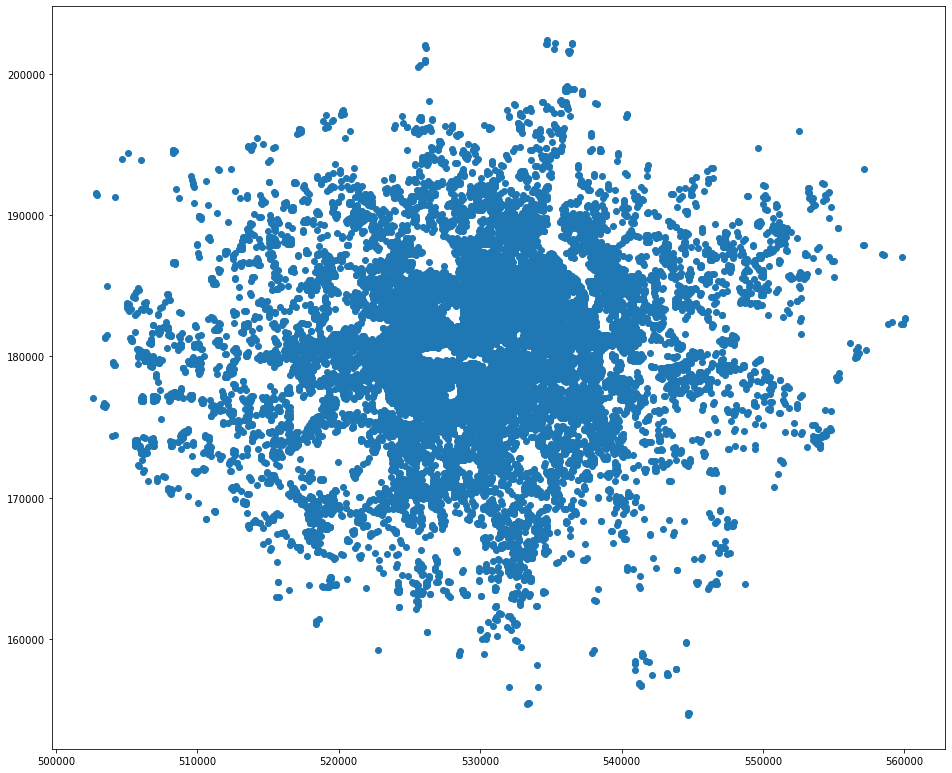

In [17]:
f,ax=plt.subplots(figsize=(16,16))
gdfprof.plot(ax=ax, legend=True, legend_kwds={'loc':'upper right', 'title':'Prof'})

In [44]:
# wl == Ward Listings
wlprof = gpd.sjoin(gdfprof, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])
wltotal = gpd.sjoin(gdftotal, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [102]:
# wl == Ward Listings
wlprof21 = gpd.sjoin(gdfprof21, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])
wltotal21 = gpd.sjoin(gdftotal21, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [19]:
# wh == Ward Hosts
whprof = gpd.sjoin(gdfprof, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])
whtotal = gpd.sjoin(gdftotal, ward[['GSS_CODE','geometry']], op='within').drop(columns=
    ['latitude','longitude','index_right','geometry'])

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [103]:
#wl group
wlprof = wlprof.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wlprof.columns.values
cols[1] = 'wlprofcount'
wlprof.columns = cols

wltotal = wltotal.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wltotal.columns.values
cols[1] = 'wltotalcount'
wltotal.columns = cols

KeyError: "Columns not found: 'id'"

In [104]:
#wl group
wlprof21 = wlprof21.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wlprof21.columns.values
cols[1] = 'wlprofcount21'
wlprof21.columns = cols

wltotal21 = wltotal21.groupby(['GSS_CODE'])[['id']].count().reset_index()
cols = wltotal21.columns.values
cols[1] = 'wltotalcount21'
wltotal21.columns = cols

In [21]:
warddata=ward.merge(wlprof, on='GSS_CODE', how='left')
warddata=warddata.merge(wltotal, on='GSS_CODE', how='left')
warddata['wlprofcount'].fillna(0)
warddata['wlprofcount'].fillna(0)
warddata.eval('wlpercent = wlprofcount / wltotalcount' , inplace=True)


,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,wlprofcount,wltotalcount,wlpercent
0,Chessington South,E05000405,755.173,0.000,E09000021,Kingston upon Thames,50840,"MULTIPOLYGON (((516401.600 160201.800, 516407....",9.0,16,0.562500
1,Tolworth and Hook Rise,E05000414,259.464,0.000,E09000021,Kingston upon Thames,117160,"MULTIPOLYGON (((517829.600 165447.100, 517837....",6.0,15,0.400000
2,Berrylands,E05000401,145.390,0.000,E09000021,Kingston upon Thames,50449,"MULTIPOLYGON (((518107.500 167303.400, 518114....",21.0,37,0.567568
3,Alexandra,E05000400,268.506,0.000,E09000021,Kingston upon Thames,50456,"MULTIPOLYGON (((520480.000 166909.800, 520490....",2.0,14,0.142857
4,Beverley,E05000402,187.821,0.000,E09000021,Kingston upon Thames,117161,"MULTIPOLYGON (((522071.000 168144.900, 522063....",15.0,33,0.454545
...,...,...,...,...,...,...,...,...,...,...,...
620,Whalebone,E05000042,155.399,0.000,E09000002,Barking and Dagenham,117022,"MULTIPOLYGON (((549410.700 187450.700, 549391....",10.0,20,0.500000
621,Eastbrook,E05000030,345.060,0.000,E09000002,Barking and Dagenham,50856,"MULTIPOLYGON (((549991.500 184928.500, 549988....",13.0,17,0.764706
622,Chadwell Heath,E05000029,338.422,0.000,E09000002,Barking and Dagenham,117014,"MULTIPOLYGON (((547715.200 187914.200, 547712....",7.0,14,0.500000
623,Parsloes,E05000037,124.384,0.000,E09000002,Barking and Dagenham,117017,"MULTIPOLYGON (((547381.600 185753.600, 547377....",4.0,9,0.444444


In [105]:
warddata21=ward.merge(wlprof21, on='GSS_CODE', how='left')
warddata21=warddata21.merge(wltotal21, on='GSS_CODE', how='left')
warddata21['wlprofcount21'].fillna(0)
warddata21['wltotalcount21'].fillna(0)
warddata21.eval('wlpercent21 = wlprofcount21 / wltotalcount21' , inplace=True)
warddata21

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,wlprofcount21,wltotalcount21,wlpercent21
0,Chessington South,E05000405,755.173,0.000,E09000021,Kingston upon Thames,50840,"MULTIPOLYGON (((516401.600 160201.800, 516407....",5.0,14,0.357143
1,Tolworth and Hook Rise,E05000414,259.464,0.000,E09000021,Kingston upon Thames,117160,"MULTIPOLYGON (((517829.600 165447.100, 517837....",2.0,11,0.181818
2,Berrylands,E05000401,145.390,0.000,E09000021,Kingston upon Thames,50449,"MULTIPOLYGON (((518107.500 167303.400, 518114....",11.0,31,0.354839
3,Alexandra,E05000400,268.506,0.000,E09000021,Kingston upon Thames,50456,"MULTIPOLYGON (((520480.000 166909.800, 520490....",4.0,15,0.266667
4,Beverley,E05000402,187.821,0.000,E09000021,Kingston upon Thames,117161,"MULTIPOLYGON (((522071.000 168144.900, 522063....",18.0,47,0.382979
...,...,...,...,...,...,...,...,...,...,...,...
620,Whalebone,E05000042,155.399,0.000,E09000002,Barking and Dagenham,117022,"MULTIPOLYGON (((549410.700 187450.700, 549391....",5.0,11,0.454545
621,Eastbrook,E05000030,345.060,0.000,E09000002,Barking and Dagenham,50856,"MULTIPOLYGON (((549991.500 184928.500, 549988....",1.0,12,0.083333
622,Chadwell Heath,E05000029,338.422,0.000,E09000002,Barking and Dagenham,117014,"MULTIPOLYGON (((547715.200 187914.200, 547712....",9.0,25,0.360000
623,Parsloes,E05000037,124.384,0.000,E09000002,Barking and Dagenham,117017,"MULTIPOLYGON (((547381.600 185753.600, 547377....",11.0,15,0.733333


In [122]:
warddataminus = gpd.sjoin(warddata, warddata21)
warddataminus.eval('wlpercentminus = wlpercent - wlpercent21' , inplace=True)

In [90]:
centraldata= warddata[warddata['BOROUGH']=='Camden''islington']
centraldata

TypeError: unsupported operand type(s) for &: 'str' and 'str'

# mapping

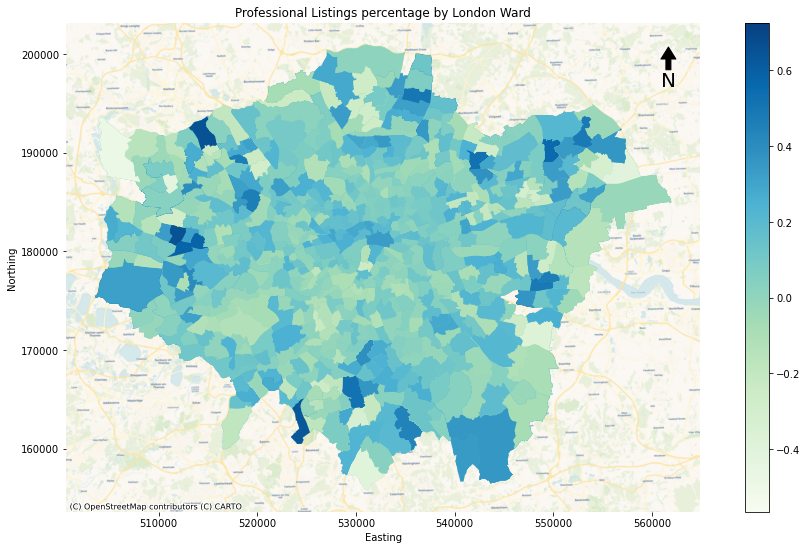

In [131]:
fig, ax = plt.subplots(figsize =(16,9))
warddataminus.plot(ax=ax, column = 'wlpercentminus', cmap = "GnBu", legend = True, figsize=(16, 9))
ax.set_title('Professional Listings percentage by London Ward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Set the labels
ax.set_xlabel("Easting");
ax.set_ylabel("Northing");
#Add north arrow, https://stackoverflow.com/a/58110049/604456
x, y, arrow_length = 0.95, 0.950, 0.07
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
contextily.add_basemap(ax, crs=warddata.crs.to_string(), source=contextily.providers.CartoDB.Voyager, zoom=12)

In [130]:
warddataminus.sort_values(by=['wlpercentminus'],ascending=False)

,NAME_left,GSS_CODE_left,HECTARES_left,NONLD_AREA_left,LB_GSS_CD_left,BOROUGH_left,POLY_ID_left,geometry,wlprofcount,wltotalcount,...,GSS_CODE_right,HECTARES_right,NONLD_AREA_right,LB_GSS_CD_right,BOROUGH_right,POLY_ID_right,wlprofcount21,wltotalcount21,wlpercent21,wlpercentminus
619,Heath,E05000034,200.128,0.0,E09000002,Barking and Dagenham,117021,"MULTIPOLYGON (((549410.700 187450.700, 549437....",17.0,21,...,E05000030,345.060,0.0,E09000002,Barking and Dagenham,50856,1.0,12,0.083333,0.726190
285,Longlands,E05000078,259.723,0.0,E09000004,Bexley,117119,"MULTIPOLYGON (((544363.400 172374.800, 544360....",9.0,12,...,E05000217,254.935,0.0,E09000011,Greenwich,117370,1.0,17,0.058824,0.691176
621,Eastbrook,E05000030,345.060,0.0,E09000002,Barking and Dagenham,50856,"MULTIPOLYGON (((549991.500 184928.500, 549988....",13.0,17,...,E05000030,345.060,0.0,E09000002,Barking and Dagenham,50856,1.0,12,0.083333,0.681373
109,Brooklands,E05000306,420.264,0.0,E09000016,Havering,116702,"MULTIPOLYGON (((548874.200 188496.300, 548875....",38.0,51,...,E05000030,345.060,0.0,E09000002,Barking and Dagenham,50856,1.0,12,0.083333,0.661765
143,Yeading,E05000344,232.126,0.0,E09000017,Hillingdon,51090,"MULTIPOLYGON (((511031.800 180894.700, 511047....",21.0,26,...,E05000181,154.182,0.0,E09000009,Ealing,50955,2.0,13,0.153846,0.653846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,Turkey Street,E05000211,226.150,0.0,E09000010,Enfield,117083,"MULTIPOLYGON (((534975.800 200166.800, 534988....",NaN,4,...,E05000207,286.704,0.0,E09000010,Enfield,117079,13.0,27,0.481481,NaN
325,Turkey Street,E05000211,226.150,0.0,E09000010,Enfield,117083,"MULTIPOLYGON (((534975.800 200166.800, 534988....",NaN,4,...,E05000211,226.150,0.0,E09000010,Enfield,117083,1.0,5,0.200000,NaN
325,Turkey Street,E05000211,226.150,0.0,E09000010,Enfield,117083,"MULTIPOLYGON (((534975.800 200166.800, 534988....",NaN,4,...,E05000195,1693.541,0.0,E09000010,Enfield,117071,2.0,7,0.285714,NaN
325,Turkey Street,E05000211,226.150,0.0,E09000010,Enfield,117083,"MULTIPOLYGON (((534975.800 200166.800, 534988....",NaN,4,...,E05000198,463.653,0.0,E09000010,Enfield,117082,2.0,19,0.105263,NaN


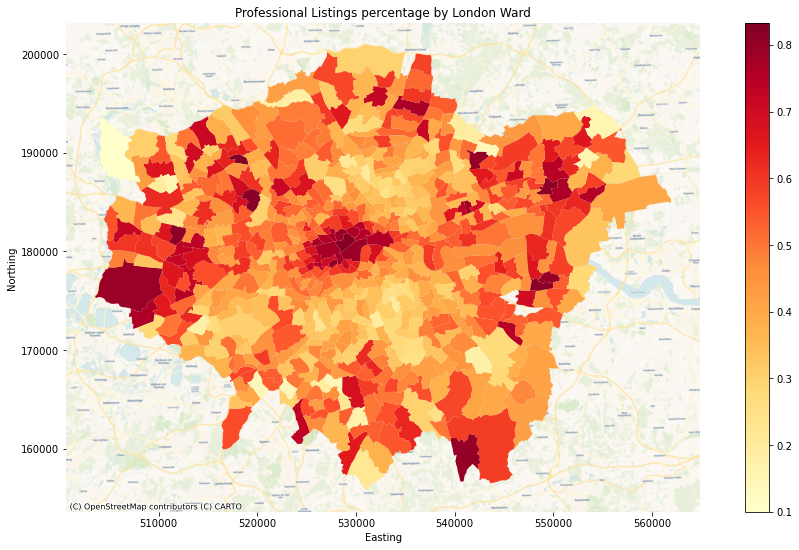

In [39]:
fig, ax = plt.subplots(figsize =(16,9))

warddata.plot(ax=ax, column = 'wlpercent', cmap = "YlOrRd", legend = True, figsize=(16, 9))
ax.set_title('Professional Listings percentage by London Ward')
plt.savefig('Professional Listings percentage by London Ward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Set the labels
ax.set_xlabel("Easting");
ax.set_ylabel("Northing");
contextily.add_basemap(ax, crs=warddata.crs.to_string(), source=contextily.providers.CartoDB.Voyager, zoom=12)


In [77]:
warddata.sort_values(by=['wlpercent'],ascending=False)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,wlprofcount,wltotalcount,wlpercent,density
163,Kenton East,E05000294,127.926,0.0,E09000015,Harrow,50511,"MULTIPOLYGON (((517098.800 189585.800, 517150....",10.0,12,0.833333,7.816857
484,West End,E05000649,199.973,0.0,E09000033,Westminster,50723,"MULTIPOLYGON (((529928.500 181049.000, 529921....",902.0,1094,0.824497,451.064459
301,Brampton,E05000068,196.746,0.0,E09000004,Bexley,50883,"MULTIPOLYGON (((547741.900 177214.700, 547777....",9.0,11,0.818182,4.574378
181,Tokyngton,E05000102,275.917,0.0,E09000005,Brent,51104,"MULTIPOLYGON (((519591.300 183969.600, 519392....",219.0,268,0.817164,79.370870
619,Heath,E05000034,200.128,0.0,E09000002,Barking and Dagenham,117021,"MULTIPOLYGON (((549410.700 187450.700, 549437....",17.0,21,0.809524,8.494478
...,...,...,...,...,...,...,...,...,...,...,...,...
124,Harefield,E05000330,1522.704,0.0,E09000017,Hillingdon,51039,"MULTIPOLYGON (((504785.000 187625.000, 504770....",1.0,10,0.100000,0.065673
131,Ickenham,E05000333,620.442,0.0,E09000017,Hillingdon,51031,"MULTIPOLYGON (((507709.400 185043.600, 507663....",NaN,8,NaN,NaN
295,Falconwood and Welling,E05000076,167.026,0.0,E09000004,Bexley,117122,"MULTIPOLYGON (((546460.400 176076.300, 546445....",NaN,5,NaN,NaN
297,Blendon and Penhill,E05000067,209.790,0.0,E09000004,Bexley,50890,"MULTIPOLYGON (((547267.700 173442.100, 547253....",NaN,2,NaN,NaN


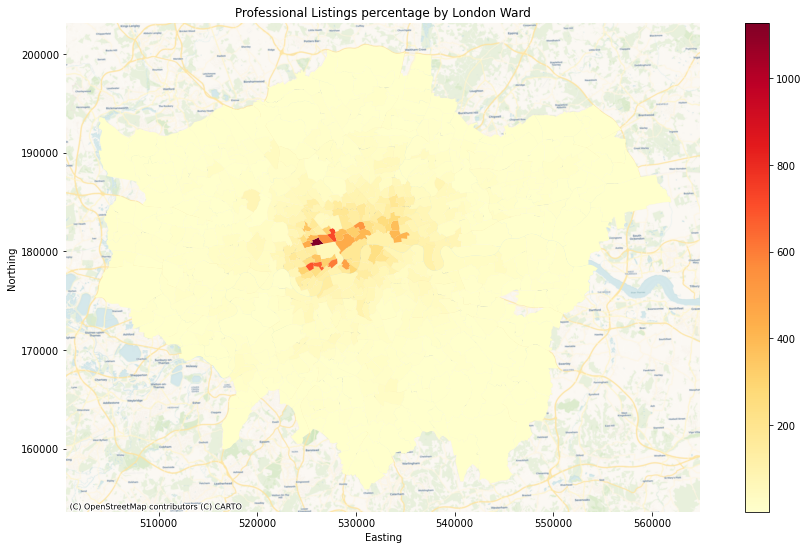

In [65]:
fig, ax = plt.subplots(figsize =(16,9))
warddata['density']=warddata['wlprofcount']*1000000/warddata.area
warddata.plot(ax=ax, column = 'density', cmap = "YlOrRd", legend = True, figsize=(16, 9))
ax.set_title('Professional Listings percentage by London Ward')
plt.savefig('Professional Listings percentage by London Ward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Set the labels
ax.set_xlabel("Easting");
ax.set_ylabel("Northing");
contextily.add_basemap(ax, crs=warddata.crs.to_string(), source=contextily.providers.CartoDB.Voyager, zoom=12)

In [78]:
warddata.sort_values(by=['density'],ascending=False)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,wlprofcount,wltotalcount,wlpercent,density
479,Lancaster Gate,E05000638,63.082,0.0,E09000033,Westminster,50773,"MULTIPOLYGON (((526231.900 181414.800, 526235....",712.0,921,0.773073,1128.688668
486,Bryanston and Dorset Square,E05000632,72.318,0.0,E09000033,Westminster,50771,"MULTIPOLYGON (((527921.900 181967.000, 527966....",520.0,682,0.762463,719.013296
473,Earl's Court,E05000388,45.828,0.0,E09000020,Kensington and Chelsea,50662,"MULTIPOLYGON (((524933.500 178522.200, 524954....",320.0,444,0.720721,698.253663
474,Courtfield,E05000386,47.760,0.0,E09000020,Kensington and Chelsea,50654,"MULTIPOLYGON (((525752.600 178859.100, 525810....",317.0,425,0.745882,663.737609
476,Hans Town,E05000390,55.234,0.0,E09000020,Kensington and Chelsea,117494,"MULTIPOLYGON (((527162.300 178408.800, 527158....",332.0,418,0.794258,601.075330
...,...,...,...,...,...,...,...,...,...,...,...,...
124,Harefield,E05000330,1522.704,0.0,E09000017,Hillingdon,51039,"MULTIPOLYGON (((504785.000 187625.000, 504770....",1.0,10,0.100000,0.065673
131,Ickenham,E05000333,620.442,0.0,E09000017,Hillingdon,51031,"MULTIPOLYGON (((507709.400 185043.600, 507663....",NaN,8,NaN,NaN
295,Falconwood and Welling,E05000076,167.026,0.0,E09000004,Bexley,117122,"MULTIPOLYGON (((546460.400 176076.300, 546445....",NaN,5,NaN,NaN
297,Blendon and Penhill,E05000067,209.790,0.0,E09000004,Bexley,50890,"MULTIPOLYGON (((547267.700 173442.100, 547253....",NaN,2,NaN,NaN


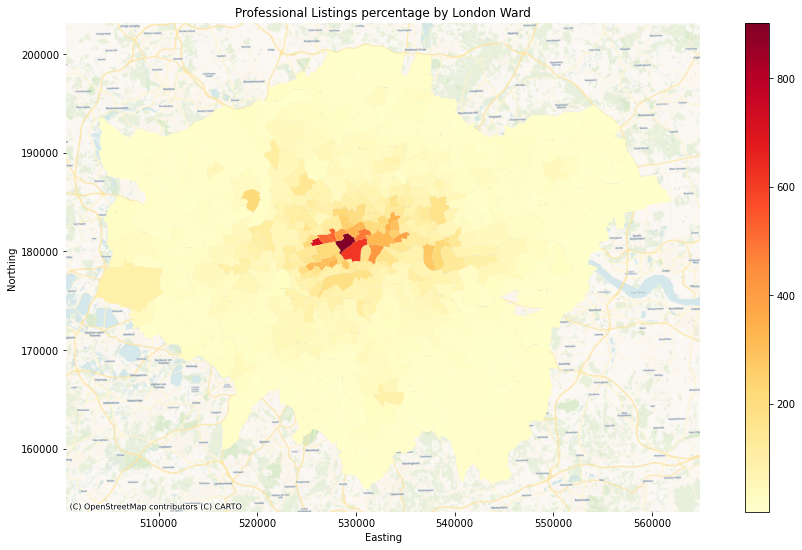

In [66]:
fig, ax = plt.subplots(figsize =(16,9))

warddata.plot(ax=ax, column = 'wlprofcount', cmap = "YlOrRd", legend = True, figsize=(16, 9))
ax.set_title('Professional Listings percentage by London Ward')
plt.savefig('Professional Listings percentage by London Ward')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# Set the labels
ax.set_xlabel("Easting");
ax.set_ylabel("Northing");
contextily.add_basemap(ax, crs=warddata.crs.to_string(), source=contextily.providers.CartoDB.Voyager, zoom=12)


In [82]:
warddata.sort_values(by=['wlprofcount'],ascending=False)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,wlprofcount,wltotalcount,wlpercent,density
484,West End,E05000649,199.973,0.000,E09000033,Westminster,50723,"MULTIPOLYGON (((529928.500 181049.000, 529921....",902.0,1094,0.824497,451.064459
479,Lancaster Gate,E05000638,63.082,0.000,E09000033,Westminster,50773,"MULTIPOLYGON (((526231.900 181414.800, 526235....",712.0,921,0.773073,1128.688668
478,St. James's,E05000644,346.379,27.146,E09000033,Westminster,117483,"MULTIPOLYGON (((530410.600 178958.500, 530281....",614.0,779,0.788190,177.261475
486,Bryanston and Dorset Square,E05000632,72.318,0.000,E09000033,Westminster,50771,"MULTIPOLYGON (((527921.900 181967.000, 527966....",520.0,682,0.762463,719.013296
481,Hyde Park,E05000636,95.514,0.000,E09000033,Westminster,50772,"MULTIPOLYGON (((527761.700 180969.800, 527714....",512.0,676,0.757396,536.069202
...,...,...,...,...,...,...,...,...,...,...,...,...
124,Harefield,E05000330,1522.704,0.000,E09000017,Hillingdon,51039,"MULTIPOLYGON (((504785.000 187625.000, 504770....",1.0,10,0.100000,0.065673
131,Ickenham,E05000333,620.442,0.000,E09000017,Hillingdon,51031,"MULTIPOLYGON (((507709.400 185043.600, 507663....",NaN,8,NaN,NaN
295,Falconwood and Welling,E05000076,167.026,0.000,E09000004,Bexley,117122,"MULTIPOLYGON (((546460.400 176076.300, 546445....",NaN,5,NaN,NaN
297,Blendon and Penhill,E05000067,209.790,0.000,E09000004,Bexley,50890,"MULTIPOLYGON (((547267.700 173442.100, 547253....",NaN,2,NaN,NaN


In [54]:
ward

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.000,E09000021,Kingston upon Thames,50840,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
1,Tolworth and Hook Rise,E05000414,259.464,0.000,E09000021,Kingston upon Thames,117160,"MULTIPOLYGON (((517829.600 165447.100, 517837...."
2,Berrylands,E05000401,145.390,0.000,E09000021,Kingston upon Thames,50449,"MULTIPOLYGON (((518107.500 167303.400, 518114...."
3,Alexandra,E05000400,268.506,0.000,E09000021,Kingston upon Thames,50456,"MULTIPOLYGON (((520480.000 166909.800, 520490...."
4,Beverley,E05000402,187.821,0.000,E09000021,Kingston upon Thames,117161,"MULTIPOLYGON (((522071.000 168144.900, 522063...."
...,...,...,...,...,...,...,...,...
620,Whalebone,E05000042,155.399,0.000,E09000002,Barking and Dagenham,117022,"MULTIPOLYGON (((549410.700 187450.700, 549391...."
621,Eastbrook,E05000030,345.060,0.000,E09000002,Barking and Dagenham,50856,"MULTIPOLYGON (((549991.500 184928.500, 549988...."
622,Chadwell Heath,E05000029,338.422,0.000,E09000002,Barking and Dagenham,117014,"MULTIPOLYGON (((547715.200 187914.200, 547712...."
623,Parsloes,E05000037,124.384,0.000,E09000002,Barking and Dagenham,117017,"MULTIPOLYGON (((547381.600 185753.600, 547377...."


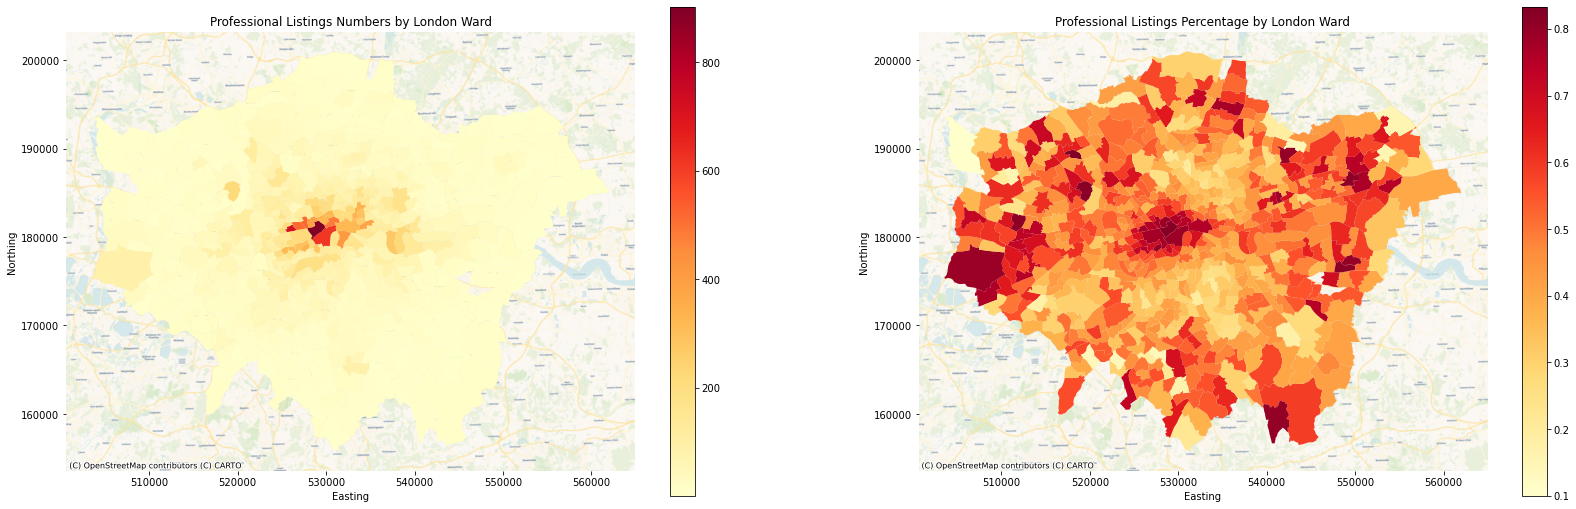

In [84]:
# Set up a 1 x 2 plot (you can also leave off the nrows= and ncols=)
f,axes = plt.subplots(nrows=1, ncols=2, figsize=(28,9))
# ax1 will be the first plot on the left, ax2 will be on the right;
# a 2 (or more) *row* plot will return a list of lists... 1 list/row.
ax1 = axes[0]
ax2 = axes[1]

# Left plot is the median price
warddata.plot(ax=ax1, column = 'wlprofcount', cmap = "YlOrRd", legend = True, figsize=(16, 9))
ax1.set_title("Professional Listings Numbers by London Ward");
# Turn off the frame, one side of the plat at a time
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
# Set the labels
ax1.set_xlabel("Easting");
ax1.set_ylabel("Northing");
contextily.add_basemap(ax1, crs=warddata.crs.to_string(), source=contextily.providers.CartoDB.Voyager, zoom=12)

# Right plot is the median price
warddata.plot(ax=ax2, column = 'wlpercent', cmap = "YlOrRd", legend = True, figsize=(16, 9))
ax2.set_title("Professional Listings Percentage by London Ward");
# Turn off the frame, one side of the plat at a time
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
# Set the labels
ax2.set_xlabel("Easting");
ax2.set_ylabel("Northing");
contextily.add_basemap(ax2, crs=warddata.crs.to_string(), source=contextily.providers.CartoDB.Voyager, zoom=12)